In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [30]:
df = pd.DataFrame(columns=['file_path', 'label', 'classic_or_not'])

In [31]:
%%capture
data_dir = './data/mel/1_classic/'
folders = ['3_symphony', '4_opera', '5_solo', '6_chamber']
for folder in folders:
    for file in os.listdir(data_dir + "/" + folder):
        df = df.append({'file_path': data_dir + folder + "/" + file, 'label': '1_classic' + "_" + folder, 'classic_or_not': 1}, ignore_index=True)

In [32]:
%%capture
data_dir = './data/mel/2_non-classic/'
folders = ['7_pop', '8_dance&house', '9_indie', '10_soul or r&b', '11_rock']
for folder in folders:
    for file in os.listdir(data_dir + "/" + folder):
        # if file is a folder, just add the files in the folder
        if os.path.isdir(data_dir + "/" + folder + "/" + file):
            for file2 in os.listdir(data_dir + "/" + folder + "/" + file):
                df = df.append({'file_path': data_dir + folder + "/" + file + "/" + file2, 'label': '2_non-classic' + "_" + folder, 'classic_or_not': 0}, ignore_index=True)
        else:
            df = df.append({'file_path': data_dir + folder + "/" + file, 'label': '2_non-classic' + "_" + folder, 'classic_or_not': 0}, ignore_index=True)

In [33]:
df.head()

,file_path,label,classic_or_not
0,./data/mel/1_classic/3_symphony/76_203.0769841...,1_classic_3_symphony,1
1,./data/mel/1_classic/3_symphony/92_244.0631065...,1_classic_3_symphony,1
2,./data/mel/1_classic/3_symphony/2_253.02310657...,1_classic_3_symphony,1
3,./data/mel/1_classic/3_symphony/57_437.0557596...,1_classic_3_symphony,1
4,./data/mel/1_classic/3_symphony/3_324.02392290...,1_classic_3_symphony,1


In [34]:
print(set(df['label']))

{'1_classic_6_chamber', '1_classic_5_solo', '2_non-classic_9_indie', '2_non-classic_8_dance&house', '2_non-classic_10_soul or r&b', '1_classic_4_opera', '1_classic_3_symphony', '2_non-classic_7_pop', '2_non-classic_11_rock'}


In [35]:
df = df.assign(label_id=(df['label'].str.split('_').str[2]).astype(int))

In [36]:
df.head()

,file_path,label,classic_or_not,label_id
0,./data/mel/1_classic/3_symphony/76_203.0769841...,1_classic_3_symphony,1,3
1,./data/mel/1_classic/3_symphony/92_244.0631065...,1_classic_3_symphony,1,3
2,./data/mel/1_classic/3_symphony/2_253.02310657...,1_classic_3_symphony,1,3
3,./data/mel/1_classic/3_symphony/57_437.0557596...,1_classic_3_symphony,1,3
4,./data/mel/1_classic/3_symphony/3_324.02392290...,1_classic_3_symphony,1,3


In [37]:
from PIL import Image
df = df.assign(img_array=df['file_path'].apply(lambda x: np.array(Image.open(x))))
df = df.assign(img_mean=df['img_array'].apply(lambda x: np.mean(x)))

In [38]:
df.head()

,file_path,label,classic_or_not,label_id,img_array,img_mean
0,./data/mel/1_classic/3_symphony/76_203.0769841...,1_classic_3_symphony,1,3,"[[[6, 3, 10], [11, 0, 24], [68, 24, 103], [71,...",95.683345
1,./data/mel/1_classic/3_symphony/92_244.0631065...,1_classic_3_symphony,1,3,"[[[5, 3, 17], [3, 1, 15], [2, 0, 14], [2, 0, 1...",77.449209
2,./data/mel/1_classic/3_symphony/2_253.02310657...,1_classic_3_symphony,1,3,"[[[0, 0, 7], [0, 0, 7], [0, 0, 5], [0, 0, 5], ...",70.243362
3,./data/mel/1_classic/3_symphony/57_437.0557596...,1_classic_3_symphony,1,3,"[[[20, 11, 30], [4, 0, 19], [36, 25, 67], [8, ...",89.155546
4,./data/mel/1_classic/3_symphony/3_324.02392290...,1_classic_3_symphony,1,3,"[[[0, 0, 4], [0, 0, 4], [0, 0, 4], [0, 0, 4], ...",80.293941


In [39]:
print(len(set(df['label_id'])))

9


In [40]:
set(df['label_id'])

{3, 4, 5, 6, 7, 8, 9, 10, 11}

In [41]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.feature import graycomatrix, graycoprops
from skimage import io
from skimage.feature import hog
from scipy.signal import find_peaks
from skimage.color import rgb2gray

def extract_image_features(file_path):
    image = io.imread(file_path)
    gray_image = rgb2gray(image)
    glcm = graycomatrix((gray_image * 255).astype('uint8'), distances=[1], angles=[0], symmetric=True, normed=True)
    
    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'dissimilarity': graycoprops(glcm, 'dissimilarity')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
    }
    # hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    # for i, value in enumerate(hog_features):
    #     features[f'hog_{i}'] = value

    frequency_energy = np.sum(gray_image, axis=1)
    
    peaks, _ = find_peaks(frequency_energy, height=0)
    
    features['num_peaks'] = len(peaks)
    features['mean_peak_height'] = np.mean(frequency_energy[peaks]) if peaks.size > 0 else 0

    if len(image.shape) == 3: 
        for i, color in enumerate(['red', 'green', 'blue']):
            hist, _ = np.histogram(image[:, :, i], bins=256, range=(0, 256))
            # Normalize the histogram
            hist = hist / np.sum(hist)
            # Add the histogram to features
            for j, val in enumerate(hist):
                features[f'hist_{color}_{j}'] = val

    return features

# Assuming df is already defined and contains the necessary data
# Add additional feature columns to the DataFrame
for index, row in df.iterrows():
    features = extract_image_features(row['file_path'])
    for key, value in features.items():
        df.at[index, key] = value

# Prepare the list of feature columns, including the histogram bins
feature_cols = ['img_mean', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
# Append histogram feature names
feature_cols += [f'hist_{color}_{j}' for color in ['red', 'green', 'blue'] for j in range(256)]

# Select features for clustering
X = df[feature_cols].values

# Perform clustering
kmeans = KMeans(n_clusters=9)  # Adjust the number of clusters appropriately
df['cluster'] = kmeans.fit_predict(X)

# Evaluate clustering quality
silhouette_avg = silhouette_score(X, df['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

/Users/anirudhramesh/miniconda3/envs/ai_env/lib/python3.7/site-packages/pandas/core/indexing.py:1684: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = infer_fill_value(value)


Silhouette Score: 0.44990340311279575


This cell will load HoG Features into the ndarray ```X_hog```, and KMeans clusters into the variable ```df['cluster_hog']```.

In [42]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.feature import graycomatrix, graycoprops
from skimage import io
from skimage.feature import hog
from scipy.signal import find_peaks
from skimage.color import rgb2gray
from skimage import data, exposure

def extract_image_hog(file_path):
    image = io.imread(file_path)
    gray_image = rgb2gray(image)
    glcm = graycomatrix((gray_image * 255).astype('uint8'), distances=[1], angles=[0], symmetric=True, normed=True)
    
    features = hog(gray_image, orientations=10, pixels_per_cell=(10, 10), cells_per_block=(2, 2))

    
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

    # ax1.axis('off')
    # ax1.imshow(image, cmap=plt.cm.gray)
    # ax1.set_title('Input image')

    # # Rescale histogram for better display
    # hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    # ax2.axis('off')
    # ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
    # ax2.set_title('Histogram of Oriented Gradients')
    # plt.show()

    return features



# Assuming df is already defined and contains the necessary data
# Add additional feature columns to the DataFrame
for index, row in df.iterrows():
    features = extract_image_hog(row['file_path'])
    if index == 0:
        X_hog = np.zeros([df.shape[0], features.shape[0]])
        print(X_hog.shape)
    X_hog[index] = features

print("Done extracting HOG. Starting KMeans...")

# Perform clustering
kmeans = KMeans(n_clusters=9)  # Adjust the number of clusters appropriately
df['cluster_hog'] = kmeans.fit_predict(X_hog)

print("Done with KMeans. Starting evaluation...")

# Evaluate clustering quality
silhouette_avg = silhouette_score(X_hog, df['cluster_hog'])
print(f'Silhouette Score: {silhouette_avg}')

(1713, 60720)
Done extracting HOG. Starting KMeans...
Done with KMeans. Starting evaluation...
Silhouette Score: 0.003065755305154807


In [43]:
print(len(df.columns))

print(df[['cluster_hog', 'label_id']])

783
      cluster_hog  label_id
0               5         3
1               2         3
2               7         3
3               2         3
4               2         3
...           ...       ...
1708            3        11
1709            3        11
1710            3        11
1711            3        11
1712            6        11

[1713 rows x 2 columns]


In [44]:
import numpy as np
from scipy.stats import mode

def cluster_purity(df, cluster_col, true_label_col):
    # Compute the purity for each cluster
    clusters = df[cluster_col].unique()
    total_correct = 0
    purity_dict = {}
    
    for cluster in clusters:
        # Get the indices of rows belonging to the current cluster
        cluster_indices = df[df[cluster_col] == cluster].index
        
        # Get the true labels of data points in the cluster
        true_labels = df.loc[cluster_indices, true_label_col]
        
        # Get the most common true label in this cluster
        most_common_label, count = mode(true_labels)
        purity = count / true_labels.shape[0]
        
        # Store purity for this cluster
        purity_dict[cluster] = purity
        
        # Keep count of total correct assignments
        total_correct += count
    
    overall_purity = total_correct / df.shape[0]
    return purity_dict, overall_purity

# Assuming 'cluster' is the column with cluster labels from k-means
# # and 'label_id' is the column with true labels
cluster_purity_dict, overall_purity = cluster_purity(df, 'cluster', 'label_id')

print(f'Purity for each cluster: {cluster_purity_dict}')
print(f'Overall Purity: {overall_purity}')


cluster_purity_dict, overall_purity = cluster_purity(df, 'cluster_hog', 'label_id')

print(f'Purity for each cluster: {cluster_purity_dict}')
print(f'Overall Purity: {overall_purity}')

Purity for each cluster: {1: array([0.36160714]), 5: array([0.23428571]), 4: array([0.19444444]), 0: array([0.20873786]), 3: array([0.20348837]), 2: array([0.39473684]), 6: array([0.53773585]), 7: array([0.28776978]), 8: array([0.625])}
Overall Purity: [0.26970228]
Purity for each cluster: {5: array([0.37162162]), 2: array([0.36401674]), 7: array([0.2519084]), 0: array([0.44363636]), 6: array([0.34415584]), 8: array([0.89393939]), 1: array([0.28030303]), 4: array([0.67391304]), 3: array([0.65714286])}
Overall Purity: [0.39054291]


In [45]:
kmeans = KMeans(n_clusters=2)  # Adjust the number of clusters appropriately
df['cluster'] = kmeans.fit_predict(X)

# Evaluate clustering quality
silhouette_avg = silhouette_score(X, df['cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.5689879920537515


In [46]:
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

# Agglomerative Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=9)  # n_clusters should be tuned for your dataset
df['cluster_agglo'] = agglo.fit_predict(X)
silhouette_agglo = silhouette_score(X, df['cluster_agglo'], metric='euclidean')
print(f'Agglomerative Silhouette Score: {silhouette_agglo}')

# Spectral Clustering
spectral = SpectralClustering(n_clusters=9, affinity='nearest_neighbors')  # n_clusters should be tuned for your dataset
df['cluster_spectral'] = spectral.fit_predict(X)
silhouette_spectral = silhouette_score(X, df['cluster_spectral'], metric='euclidean')
print(f'Spectral Clustering Silhouette Score: {silhouette_spectral}')

Agglomerative Silhouette Score: 0.42291767875459374
Spectral Clustering Silhouette Score: 0.42721608503252756


In [47]:
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

# Agglomerative Hierarchical Clustering
agglo = AgglomerativeClustering(n_clusters=2)  # n_clusters should be tuned for your dataset
df['cluster_agglo'] = agglo.fit_predict(X)
silhouette_agglo = silhouette_score(X, df['cluster_agglo'], metric='euclidean')
print(f'Agglomerative Silhouette Score: {silhouette_agglo}')

# Spectral Clustering
spectral = SpectralClustering(n_clusters=2, affinity='nearest_neighbors')  # n_clusters should be tuned for your dataset
df['cluster_spectral'] = spectral.fit_predict(X)
silhouette_spectral = silhouette_score(X, df['cluster_spectral'], metric='euclidean')
print(f'Spectral Clustering Silhouette Score: {silhouette_spectral}')

Agglomerative Silhouette Score: 0.5690662501277243
Spectral Clustering Silhouette Score: 0.568766811620616


In [48]:
results = {}

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
import pickle

In [56]:
results ={}
results_xy = {}

In [65]:
# Encoding the labels

# Ture when loading saved model.
LOAD = False

Feature_type = {
                "Hog" : X_hog, #HoG features
                "old" : df[feature_cols].values # The features you've extracted earlier
                }

for name_feat, feat in Feature_type.items():
    # Features and labels
    # X = df[feature_cols].values  
    X = feat
    y = df['label_id'].values
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    svm_params = {
        'C': uniform(1, 10),
       # 'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto']
    }

    rf_params = {
        'n_estimators': sp_randint(50, 150),
        'max_depth' : [None, 10, 20, 30],
       # 'min_samples_split': sp_randint(2, 11),
      #  'min_samples_leaf': sp_randint(1, 11)
    }

     # Initialize models
    logistic_model = LogisticRegression(max_iter=100000)
    svm_model = SVC()
    random_forest_model = RandomForestClassifier()
    # gradient_boosting_model = GradientBoostingClassifier()

    models = {
            'Logistic Regression': logistic_model,
            'SVM': svm_model,
            'Random Forest': random_forest_model,
        # 'Gradient Boosting': gradient_boosting_model
    }

   
    if not LOAD:
        models['SVM'] = RandomizedSearchCV(models['SVM'], svm_params, n_iter = 5, cv=3, random_state = 42, n_jobs=-1)
        models['Random Forest'] = RandomizedSearchCV(models['Random Forest'], rf_params, n_iter=5, cv=3, n_jobs=-1, random_state=42)

    # Train and evaluate models
        
    
    else:
        for name,_ in models.items():
            with open("./model/" + name_feat + "_" + name + '_model.pkl', 'rb') as f:
                models[name] = pickle.load(f)

    for name, model in models.items():
        if not LOAD:
            model.fit(X_train, y_train)

            if name in ['SVM', 'Random Forest']:
                print(f"Best Hyperparameters for {name_feat} feature {name}: {model.best_params_}")
                models[name] = model.best_estimator_
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name_feat+" feature "+name] = accuracy
        print(name_feat + "_" + name + ":", accuracy)
        
        results_xy[name_feat + " " + name + " X_test"] = X_test
        results_xy[name_feat + " " + name + " y_test"] = y_test
        results_xy[name_feat + " " + name + " y_pred"] = y_pred

        if not LOAD:
            # save model
            with open("./model/" + name_feat + "_" + name + '_model.pkl','wb') as f:
                pickle.dump(model,f)

for result_name, accuracy in results.items():
    print(f"{result_name}: {accuracy}")

Hog_Logistic Regression: 0.5393586005830904


python(54120) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54121) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54122) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54123) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54124) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54125) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54126) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54127) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Best Hyperparameters for Hog feature SVM: {'C': 4.745401188473625, 'gamma': 'scale'}
Hog_SVM: 0.565597667638484
Best Hyperparameters for Hog feature Random Forest: {'max_depth': 20, 'n_estimators': 101}
Hog_Random Forest: 0.47230320699708456
old_Logistic Regression: 0.42565597667638483
Best Hyperparameters for old feature SVM: {'C': 1.5808361216819946, 'gamma': 'auto'}
old_SVM: 0.32653061224489793
Best Hyperparameters for old feature Random Forest: {'max_depth': None, 'n_estimators': 64}
old_Random Forest: 0.6034985422740525
Hog feature Logistic Regression: 0.5393586005830904
Hog feature SVM: 0.565597667638484
Hog feature Random Forest: 0.47230320699708456
old feature Logistic Regression: 0.42565597667638483
old feature SVM: 0.32653061224489793
old feature Random Forest: 0.6034985422740525
classicOrNot Logistic Regression: 0.9067055393586005
classicOrNot SVM: 0.8075801749271136
classicOrNot Random Forest: 0.9591836734693877
classicOrNot Gradient Boosting: 0.9620991253644315


In [67]:
LOAD = False

X = df[feature_cols].values  # The features you've extracted earlier
y = df['classic_or_not'].values

# y is either 0 or 1, so we can use LabelEncoder to encode it into a binary vector
le = LabelEncoder()
y = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svm_params = {
    'C': uniform(0.1, 10),
    'gamma': ['scale', 'auto']
}

rf_params = {
    'n_estimators': sp_randint(100, 200),
    'max_depth': [10, 20, 30, None]
}

# Initialize models
logistic_model = LogisticRegression(max_iter=100000) #100000
svm_model = RandomizedSearchCV(SVC(), svm_params, n_iter=10, cv=3, random_state=42, n_jobs=-1)
random_forest_model = RandomizedSearchCV(RandomForestClassifier(), rf_params, n_iter=10, cv=3, random_state=42, n_jobs=-1)
gradient_boosting_model = GradientBoostingClassifier()

# Train and evaluate models
models = {
    'Logistic Regression': logistic_model,
    'SVM': svm_model,
    'Random Forest': random_forest_model,
    'Gradient Boosting': gradient_boosting_model
}

# # load model
# for name, model in models.items():
#     with open(name + '_model.pkl', 'rb') as f:
#         models[model] = pickle.load(f)

if LOAD:
    for name,_ in models.items():
        with open("./model/" + "classicOrNot " + name + '_model.pkl', 'rb') as f:
            models[name] = pickle.load(f)

for name, model in models.items():
    if not LOAD:
        model.fit(X_train, y_train)
        print("Training model....")

        if name in ['SVM', 'Random Forest']:
            print(f"Best hyperparameters for {name}: {model.best_params_}")
            models[name] = model.best_estimator_
            
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results["classicOrNot " + name] = accuracy
    print(name + ":", accuracy)

    results_xy["classicOrNot " + name + " X_test"] = X_test
    results_xy["classicOrNot " + name + " y_test"] = y_test
    results_xy["classicOrNot " + name + " y_pred"] = y_pred

    if not LOAD:
        # save model
        with open("./model/" + "classicOrNot " + name + '_model.pkl','wb') as f:
            pickle.dump(model,f)
for result_name, accuracy in results.items():
    print(f"{result_name}: {accuracy}")

Training model....
Logistic Regression: 0.9300291545189504


python(54613) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54614) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54615) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54616) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54617) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54618) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54619) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54620) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Training model....
Best hyperparameters for SVM: {'C': 0.6808361216819946, 'gamma': 'auto'}
SVM: 0.9271137026239067
Training model....
Best hyperparameters for Random Forest: {'max_depth': 10, 'n_estimators': 199}
Random Forest: 0.9504373177842566
Training model....
Gradient Boosting: 0.9533527696793003
Hog feature Logistic Regression: 0.5393586005830904
Hog feature SVM: 0.565597667638484
Hog feature Random Forest: 0.47230320699708456
old feature Logistic Regression: 0.42565597667638483
old feature SVM: 0.32653061224489793
old feature Random Forest: 0.6034985422740525
classicOrNot Logistic Regression: 0.9300291545189504
classicOrNot SVM: 0.9271137026239067
classicOrNot Random Forest: 0.9504373177842566
classicOrNot Gradient Boosting: 0.9533527696793003


(1713, 60720)


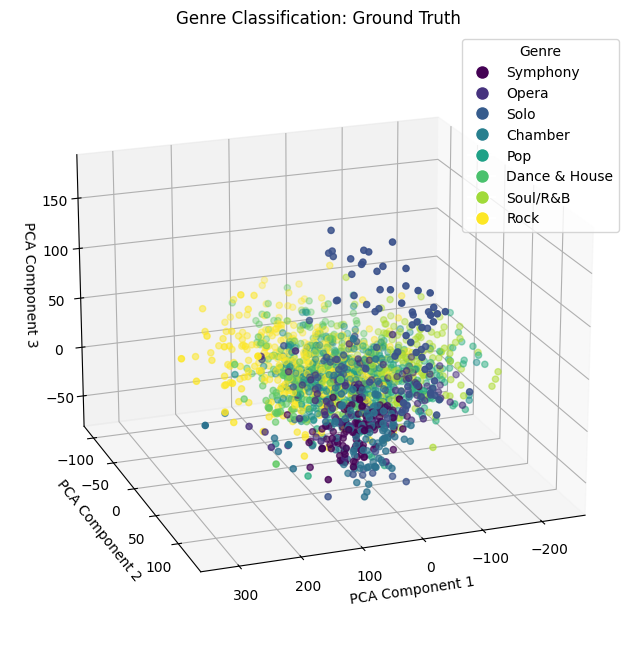

(1713, 774)


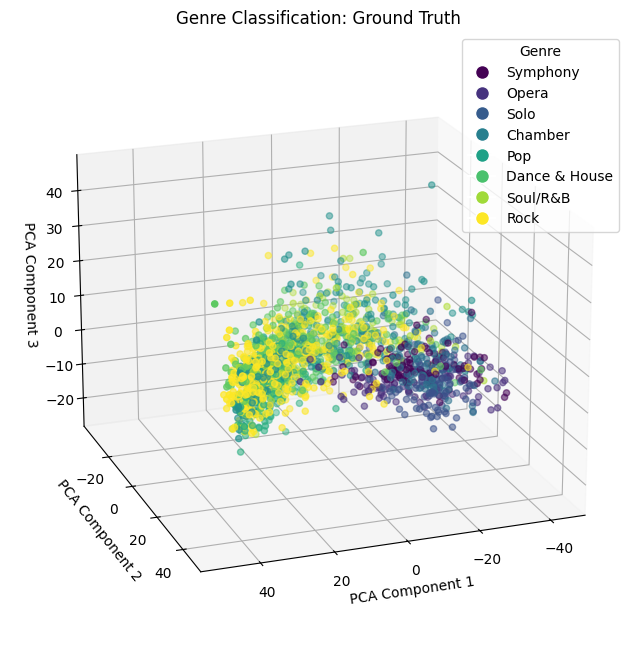

In [99]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

Feature_type = {
                "Hog" : X_hog, #HoG features
                "old" : df[feature_cols].values # The features you've extracted earlier
                }

for name_feat, feat in Feature_type.items():

    X = feat
    print(X.shape)
    y = df['label_id'].values
    y_hat = df['cluster'].values

    class_labels = ['Classic', 'Non-Classic', 'Symphony', 'Opera', 'Solo', 'Chamber', 'Pop', 'Dance & House', 'Soul/R&B', 'Rock']

    # Standardize the data
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    # Perform PCA on standardized data
    pca = PCA(n_components=3)
    X_pca = pca.fit_transform(X_standardized)

    # Create a static 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot for Ground Truth (y)
    scatter1 = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', marker='o')

    # Set labels for axes and title
    ax.set_title('Genre Classification: Ground Truth')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')

    # Manually create the legend with correct colors
    legend_labels = class_labels[2:]  # excluding 'Classic' and 'Non-Classic'
    unique_colors = plt.cm.viridis(np.linspace(0, 1, len(legend_labels)))

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in unique_colors]
    ax.legend(handles, legend_labels, title='Genre')

    # Rotate the plot
    ax.view_init(elev=20, azim=70)  # Adjust the elevation and azimuth angles for rotation

    plt.show()

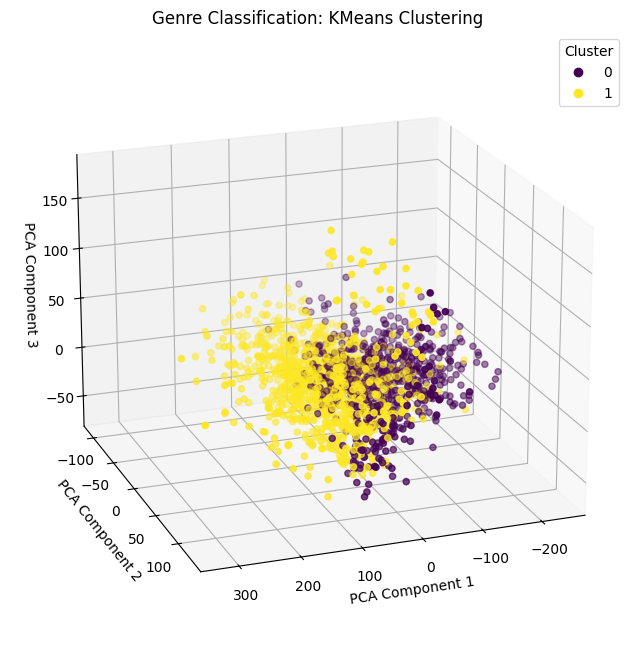

In [107]:

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

# X = df[feature_cols].values
X = X_hog
y = df['cluster'].values

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Perform PCA on standardized data
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_standardized)

# Create a static 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot for Ground Truth (y)
scatter1 = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', marker='o')
ax.set_title('Genre Classification: KMeans Clustering')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend(*scatter1.legend_elements(), title='Cluster')

# Rotate the plot
ax.view_init(elev=20, azim=70)  # Adjust the elevation and azimuth angles for rotation

plt.show()

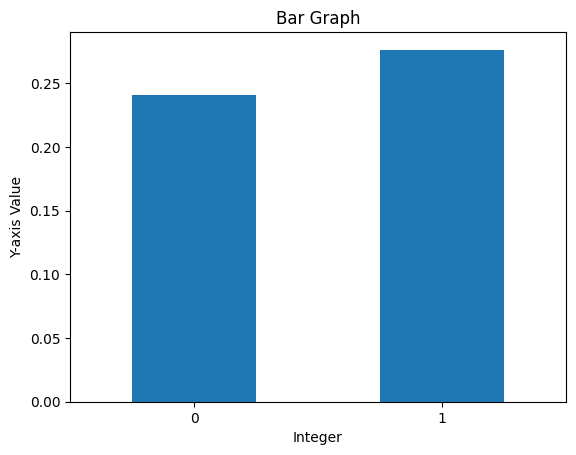

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

def getPurityBarGraph(purities):
    # Convert the dictionary to pandas DataFrame
    pdf = pd.DataFrame.from_dict(purities, orient='index', columns=['Value'])

    # Sort the DataFrame by the index (Integer values)
    pdf = pdf.sort_index()

    # Plot the bar graph
    pdf.plot(kind='bar', legend=False)
    
    plt.xlabel('Integer')
    plt.ylabel('Y-axis Value')
    plt.title('Bar Graph')
    plt.xticks(rotation=0)
    plt.show()

# Example usage:
purities, _ = cluster_purity(df, 'cluster', 'label_id')
getPurityBarGraph(purities)

# purities, _ = cluster_purity(df, 'cluster_hog', 'label_id')
# getPurityBarGraph(purities)

In [230]:
def getAccuracyBarGraph(results):
    
    models = ['Logistic Regression', 'SVM', 'Random Forest']
    hog_values = [results[f'Hog feature {model}'] for model in models]
    old_values = [results[f'old feature {model}'] for model in models]

    bar_width = 0.35
    index = np.arange(len(models))

    plt.figure(figsize=(10, 6))

    plt.bar(index, hog_values, bar_width, color='green', label='HoG feature')
    plt.bar(index + bar_width, old_values, bar_width, color='blue', label='GLCM and correlation features')

    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Model Accuracy by Feature and Algorithm')
    plt.xticks(index + bar_width / 2, models)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [94]:
results

{'Hog feature Logistic Regression': 0.5393586005830904,
 'Hog feature SVM': 0.46647230320699706,
 'Hog feature Random Forest': 0.4489795918367347,
 'old feature Logistic Regression': 0.42857142857142855,
 'old feature SVM': 0.27113702623906705,
 'old feature Random Forest': 0.6268221574344023}

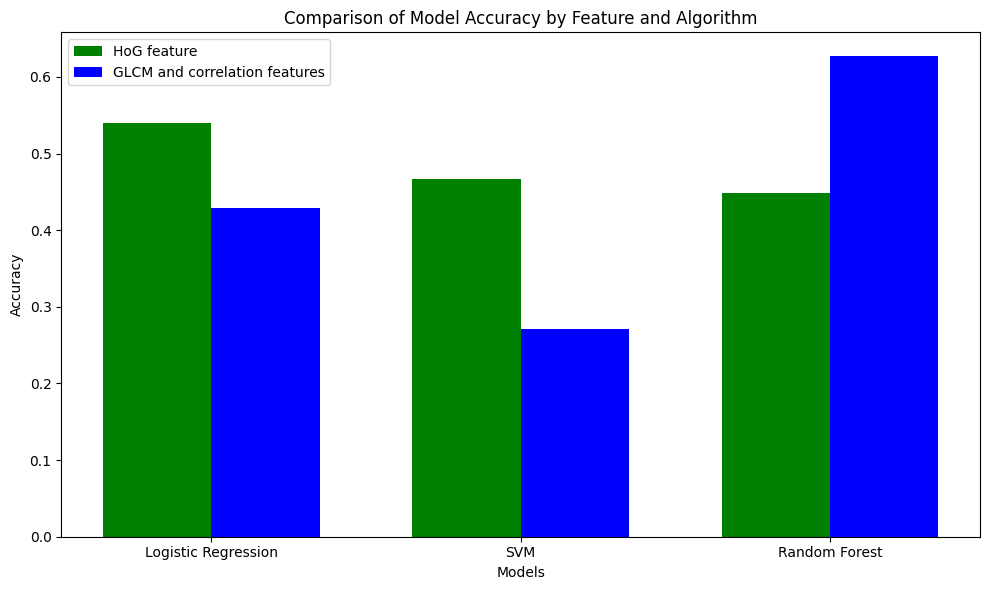

In [114]:
getAccuracyBarGraph(results)

In [190]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
def predict_vis(results_xy, pca) :
    X = results_xy["Hog Logistic Regression X_test"]
    y = results_xy["Hog Logistic Regression y_test"]
    y_hat = results_xy["Hog Logistic Regression y_pred"]

    class_labels = ['Classic', 'Non-Classic', 'Symphony', 'Opera', 'Solo', 'Chamber', 'Pop', 'Dance & House', 'Soul/R&B', 'Rock']

    # Standardize the data
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X)

    # Perform PCA on standardized data

    X_pca = pca.transform(X_standardized)

    # Create a static 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot for Ground Truth (y)
    scatter1 = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis', marker='o')

    # Set labels for axes and title
    ax.set_title('Genre Classification: Ground Truth')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    # ax.set_aspect("equal")

    # Manually create the legend with correct colors
    legend_labels = class_labels[2:]  # excluding 'Classic' and 'Non-Classic'
    unique_colors = plt.cm.viridis(np.linspace(0, 1, len(legend_labels)))

    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in unique_colors]
    ax.legend(handles, legend_labels, title='Genre')

    ax.scatter(X_pca[(y-y_hat)!=0][:,0], X_pca[(y-y_hat)!=0][:,1], X_pca[(y-y_hat)!=0][:,2], marker='x', color='black', s=50)

    # Rotate the plot
    ax.view_init(elev=20, azim=70)  # Adjust the elevation and azimuth angles for rotation
    plt.ion()
    plt.show()

(1713, 60720)
(1713, 3)


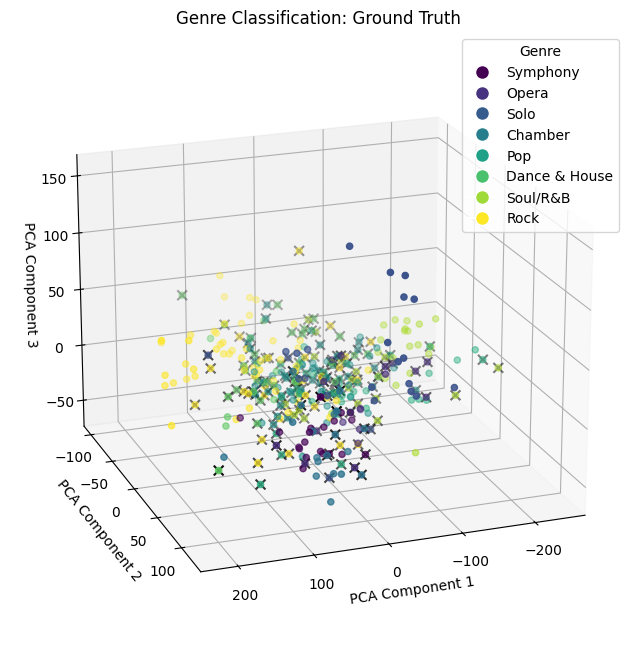

In [191]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

X = X_hog
print(X.shape)

# Standardize the data
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Perform PCA on standardized data
pca = PCA(n_components=3)
a = pca.fit_transform(X_standardized)
print(a.shape)

predict_vis(results_xy, pca)

accuracy : 
0.5393586005830904


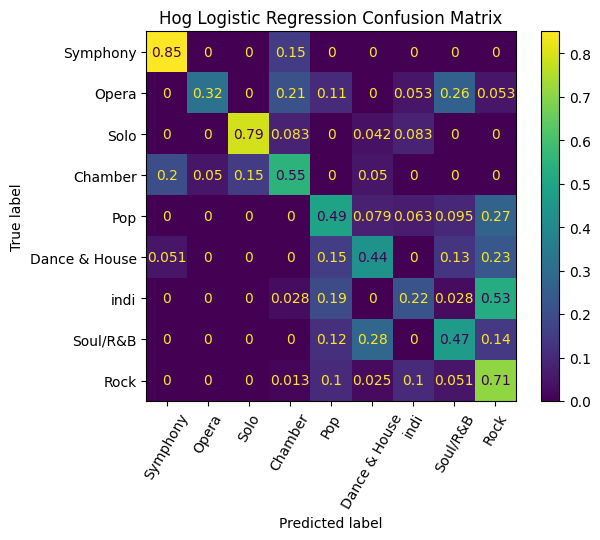

accuracy : 
0.46647230320699706


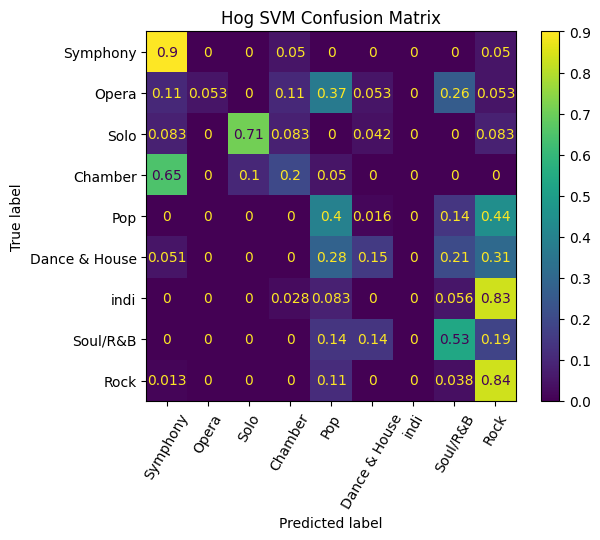

accuracy : 
0.4489795918367347


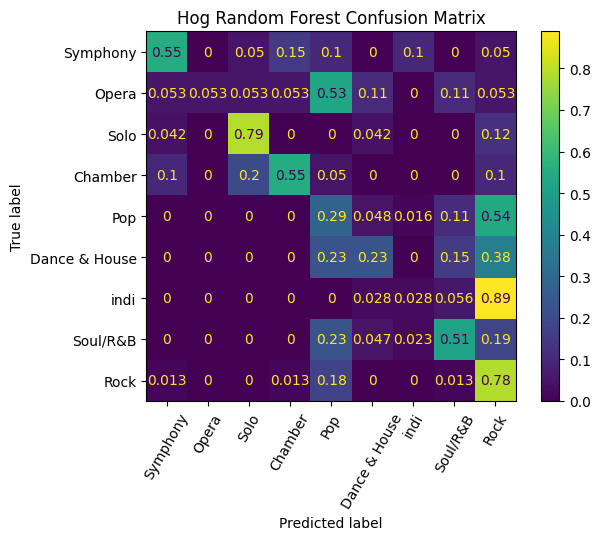

accuracy : 
0.42857142857142855


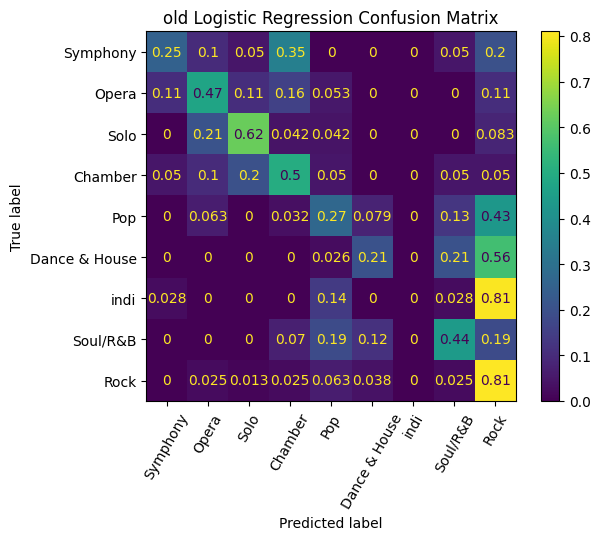

accuracy : 
0.27113702623906705


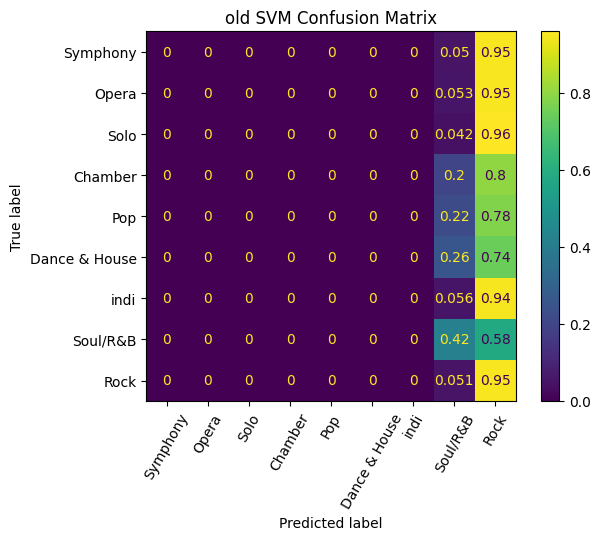

accuracy : 
0.6268221574344023


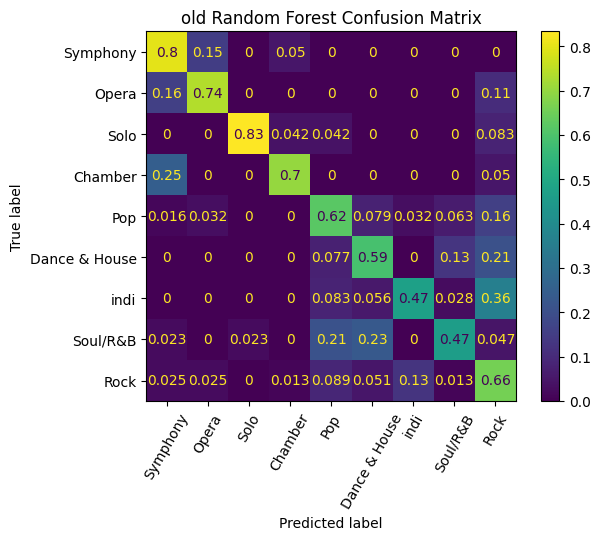

In [244]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models = ['Logistic Regression', 'SVM', 'Random Forest']
feature = ['Hog', 'old']

for feat_name in feature:
    for model_name in models:

        y = results_xy[f'{feat_name} {model_name} y_test']
        y_hat = results_xy[f'{feat_name} {model_name} y_pred']

        y = y-3
        y_hat = y_hat-3

        print("accuracy : ")
        print(results[f'{feat_name} feature {model_name}'])

        class_labels = ['Symphony', 'Opera', 'Solo', 'Chamber', 'Pop', 'Dance & House','indi', 'Soul/R&B', 'Rock']

        y = [class_labels[i] for i in y]
        y_hat = [class_labels[i] for i in y_hat]

        cm = confusion_matrix(y, y_hat, normalize = "true", labels=class_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=class_labels)
        disp.plot()

        plt.xticks(rotation=60)
        plt.title(f'{feat_name} {model_name} Confusion Matrix')
        # plt.tight_layout()
        plt.show()